In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import operator
import warnings
warnings.filterwarnings('ignore')
import os
from queue import PriorityQueue
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import pickle as pkl
from sacrebleu import raw_corpus_bleu
import math, copy, time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
#Define constants here
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 32
TEST_BATCH_SIZE = 3
words_to_load = 80000
d_model = emb_size = 300
wiki_size = 300
CUDA = True
MAX_LENGTH = 50
hidden_size = 300

In [3]:
ftdir = '/scratch/yz4499/fasttext/'

In [4]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 3

class Lang:
    def __init__(self, name, emb_word2id, emb_id2word, emb_ordered_words):
        self.name = name
        self.word2index = emb_word2id
        self.word2count = {}
        self.index2word = emb_id2word #Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #This line is commented out since it will not properly deal with Chinese Letters
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#reference: LAB4 hw2
def indexesFromSentences(lang1, lang2, pairs):
    id_list1 = []
    id_list2 = []
    for i in range(len(pairs)):
        sentence1 = pairs[i][0]
        sentence2 = pairs[i][1]
        
        sentence1 = sentence1.replace('quot','')
        sentence1 = sentence1.replace('apos', '')
        sentence2 = sentence2.replace('quot','')
        sentence2 = sentence2.replace('apos', '')
        #If either sentence is empty, then remove the pair
        if sentence1 == '' or sentence2 == '':
            continue;
        
        id_sentence1 = [lang1.word2index[word] if word in lang1.word2index else UNK_TOKEN 
                        for word in sentence1.split()] + [EOS_TOKEN]
        id_list1.append(id_sentence1)
        id_sentence2 = [lang2.word2index[word] if word in lang2.word2index else UNK_TOKEN 
                        for word in sentence2.split()] + [EOS_TOKEN]
        id_list2.append(id_sentence2)
        
   
        
    return id_list1,id_list2

In [37]:
#Reference Lab4 HW2
datadir = os.getcwd()
words_to_load = 50000
# with open(datadir + '/data/wiki-news-300d-1M.vec') as f:
with open(ftdir + 'wiki-news-300d-1M.vec') as f:
    loaded_en_embeddings = np.zeros(((words_to_load+4), wiki_size))
    en_word2id = {}
    en_id2words = {}
    
    en_id2words[PAD_TOKEN] = '<PAD>'
    en_id2words[SOS_TOKEN] = '<SOS>'
    en_id2words[EOS_TOKEN] = '<EOS>'
    en_id2words[UNK_TOKEN] = '<UNK>'
    
    en_word2id['<PAD>'] = PAD_TOKEN
    en_word2id['<SOS>'] = SOS_TOKEN
    en_word2id['<EOS>'] = EOS_TOKEN
    en_word2id['<UNK>'] = UNK_TOKEN
    
    en_ordered_words= []
    en_ordered_words.append('<PAD>')
    en_ordered_words.append('<SOS>')
    en_ordered_words.append('<EOS>')
    en_ordered_words.append('<UNK>')
    
    for i, line in enumerate(f):
        if i >= words_to_load:
            break
        if i ==0:#Ignore the first line
            continue;
        s = line.split()
        #print(len(s))
        loaded_en_embeddings[i+4,:] = np.asarray(s[1:])
        en_word2id[s[0]] = i+4 #for extra pad and unk eos and unk
        en_id2words[i+4] = s[0]
        en_ordered_words.append(s[0])

In [5]:
#Reference Lab4 HW2
#Over 200000 loaded words, only 10 has wrong dimensions, simply discarded
words_to_load = 50000
# datadir = os.getcwd()
# with open(datadir + '/data/wiki.zh.vec') as f:
with open(ftdir + 'cc.zh.300.vec') as f:
    loaded_zh_embeddings = np.zeros(((words_to_load+4),wiki_size))
    zh_word2id = {}
    zh_id2words = {}
    
    zh_id2words[PAD_TOKEN] = '<PAD>'
    zh_id2words[SOS_TOKEN] = '<SOS>'
    zh_id2words[EOS_TOKEN] = '<EOS>'
    zh_id2words[UNK_TOKEN] = '<UNK>'
    
    zh_word2id['<PAD>'] = PAD_TOKEN
    zh_word2id['<SOS>'] = SOS_TOKEN
    zh_word2id['<EOS>'] = EOS_TOKEN
    zh_word2id['<UNK>'] = UNK_TOKEN
    
    zh_ordered_words= []
    zh_ordered_words.append('<PAD>')
    zh_ordered_words.append('<SOS>')
    zh_ordered_words.append('<EOS>')
    zh_ordered_words.append('<UNK>')
    
    for i, line in enumerate(f):
        #print(i)
        if i >= words_to_load:
            break;
        if i == 0: #Ignore the first line
            continue;
        s = line.split()
        if len(s) != 301:
            print('Wrong dimension, skip')
            continue;
        loaded_zh_embeddings[i+4,:] = np.asarray(s[1:])
        zh_word2id[s[0]] = i+4 #for extra pad and unk 
        zh_id2words[i+4] = s[0]
        zh_ordered_words.append(s[0])

In [17]:
# #loading data
zh_train_pairs_cleaned = pkl.load(open('./data/zh_train_pairs_cleaned.p', 'rb'))
zh_val_pairs_cleaned = pkl.load(open('./data/zh_val_pairs_cleaned.p', 'rb'))
zh_test_pairs_cleaned = pkl.load(open('./data/zh_test_pairs_cleaned.p', 'rb'))

# vi_train_pairs_cleaned = pkl.load(open('./data/vi_train_pairs_cleaned.p', 'rb'))
# vi_val_pairs_cleaned = pkl.load(open('./data/vi_val_pairs_cleaned.p', 'rb'))
# vi_test_pairs_cleaned = pkl.load(open('./data/vi_test_pairs_cleaned.p', 'rb'))

In [18]:
class NMTDataset(Dataset):
    def __init__(self, pairs):#Needs the index pairs
        self.pairs = pairs
#         self.input_lang = input_lang
#         self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
#         padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        padded_seqs = torch.zeros(len(seqs), MAX_LENGTH).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    input_list = torch.from_numpy(np.array(padded_input))
    input_length = torch.LongTensor(input_lens)
    output_list = torch.from_numpy(np.array(padded_output))
    output_length = torch.LongTensor(output_lens)
    
    if CUDA:
        input_list = input_list.cuda()
        output_list = output_list.cuda()
        input_length = input_length.cuda()
        output_length = output_length.cuda()
            
    return [input_list, input_length, output_list, output_length]

In [19]:
BATCH_SIZE = 32
'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
TODO: output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
# train_zh_dataset = NMTDataset(zh_train_pairs_cleaned, input_zh, output_zh_en)
# train_vi_dataset = NMTDataset(vi_train_pairs_cleaned, input_vi, output_vi_en)
# val_zh_dataset = NMTDataset(zh_val_pairs_cleaned, input_zh, output_zh_en)
# val_vi_dataset = NMTDataset(vi_val_pairs_cleaned, input_vi, output_vi_en)
# test_zh_dataset = NMTDataset(zh_test_pairs_cleaned, input_zh, output_zh_en)
# test_vi_dataset = NMTDataset(vi_test_pairs_cleaned, input_vi, output_vi_en)

train_zh_dataset = NMTDataset(zh_train_pairs_cleaned)
# train_vi_dataset = NMTDataset(vi_train_pairs_cleaned)
val_zh_dataset = NMTDataset(zh_val_pairs_cleaned)
# val_vi_dataset = NMTDataset(vi_val_pairs_cleaned)
test_zh_dataset = NMTDataset(zh_test_pairs_cleaned)
# test_vi_dataset = NMTDataset(vi_test_pairs_cleaned)


train_zh_loader = torch.utils.data.DataLoader(dataset = train_zh_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)

# train_vi_loader = torch.utils.data.DataLoader(dataset = train_vi_dataset, 
#                                           batch_size = BATCH_SIZE,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = True)

#Will use batch size 1 for validation and test since the sentence will be translated one by one
val_zh_loader = torch.utils.data.DataLoader(dataset = val_zh_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
# val_vi_loader = torch.utils.data.DataLoader(dataset = val_vi_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
test_zh_loader = torch.utils.data.DataLoader(dataset = test_zh_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
# test_vi_loader = torch.utils.data.DataLoader(dataset = test_vi_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
#Input_batch in size Batch x maxLen


In [20]:
for i, (input_list, input_length, output_list, output_length) in enumerate(train_zh_loader):
    if i== 1000:
        break

In [21]:
input_list.size()

torch.Size([32, 50])

In [22]:
#Here for the constant definition
# MAX_SENTENCE_LENGTH = 10
hidden_size = 300
max_length = 10
BATCH_SIZE = 3
TEST_BATCH_SIZE = 3
# CLIP = 50
TEACHER_RATIO = 0.5
# EN_ORDERED_NUM = 200003
# ZH_ORDERED_NUM = 199945
# VI_ORDERED_NUM = 199993


In [23]:
class Embeddings(nn.Module):
    def __init__(self, emb, d_model, vocab):
        super(Embeddings, self).__init__()
        self.emb = emb
        self.lut = nn.Embedding.from_pretrained(self.emb, False, False)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [24]:
#Reference: https://stackoverflow.com/questions/52922445/runtimeerror-exp-not-implemented-for-torch-longtensor
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
       
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [25]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [26]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [27]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [28]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [29]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [30]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [31]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [32]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [33]:
class SelfEncoder(nn.Module):
    """
    A self attention based Encoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, src_embed):
        super(SelfEncoder, self).__init__()
        self.encoder = encoder
        #self.decoder = decoder
        self.src_embed = src_embed
        #self.tgt_embed = tgt_embed
        #self.generator = generator
        
    def forward(self, src, src_mask=None):
        "Take in and process masked src and target sequences."
        return self.encoder(self.src_embed(src), src_mask)
    

In [34]:
def make_model(emb, src_vocab, N=6, 
               d_model=300, d_ff=2048, h=6, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = SelfEncoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(emb, d_model, src_vocab), c(position)))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [25]:
# #Reference: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
# #Reference: lab8 1_nmt, lab8 3_mri
# class PreAttnDecoderRNN(nn.Module):
#     def __init__(self, emb, emb_size, hidden_size, output_size, n_layers=1, dropout_p=0.1):
#         super(PreAttnDecoderRNN, self).__init__()
#         self.emb = emb
#         self.emb_size = emb_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size#vocab size of the output lang
#         self.n_layers = n_layers
#         self.dropout = nn.Dropout(dropout_p)

#         self.embedding = nn.Embedding.from_pretrained(self.emb, False, False,)
        
#         #self.attn = nn.Linear(hidden_size*, hidden_size)
#         #self.attn2 = nn.Linear(hidden_size, hidden_size)
# #         self.v = nn.Parameter(torch.rand(hidden_size))
#         self.concat = nn.Linear(2*hidden_size, hidden_size)
#         self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout = dropout_p)
#         self.out = nn.Linear(hidden_size, output_size)
        
    
#     def forward(self, word_input, last_hidden, encoder_outputs):
#         #Here encoder_outputs is in size batch x max_seq x d_model
#         self.batch_size = encoder_outputs.size(0)
#         max_len = encoder_outputs.size(1)
#         attn_energies = Variable(torch.zeros(self.batch_size, max_len)).to(device)#B X max_len
# #         attn_energies = attn_energies.cuda() if CUDA else attn_energies
        
        
#         embedded = self.embedding(word_input)
#         embedded = self.dropout(embedded)
#         embedded = embedded.view(1, self.batch_size, -1) # S=1 x B x N
        
#         # Get current hidden state from input word and last hidden state
#         rnn_output, hidden = self.gru(embedded, last_hidden)
#         #rnn layer x batch x h
#         #encoder-outputs  max_len x batch x h
        
# #         for b in range(self.batch_size):
# #             # Calculate energy for each encoder output
# #             for i in range(max_len):
# #                 attn_energies[b, i] = (rnn_output[:, b].squeeze()).dot(encoder_outputs[i, b])
        
#         # Calculate attention from current RNN state and all encoder outputs;
#         #More efficient
#         #attn_energies = ((rnn_output.transpose(0,1)).bmm(encoder_outputs.transpose(0,1).transpose(1,2))).squeeze(1)
#         attn_energies = ((rnn_output.transpose(0,1)).bmm(encoder_outputs.transpose(1,2))).squeeze(1)

#         attn_weights = F.softmax(attn_energies) # B x max_len
#         attn_weights = attn_weights.unsqueeze(1)
#         # apply to encoder outputs to get weighted average
#         context = attn_weights.bmm(encoder_outputs) # B x S=1 x N
        
#         # Attentional vector using the RNN hidden state and context vector

#         # concatenated together (Luong eq. 5)
#         rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
#         context = context.squeeze(1)       # B x S=1 x N -> B x N
#         concat_input = torch.cat((rnn_output, context), 1)
#         concat_output = F.tanh(self.concat(concat_input))

#         # Finally predict next token (Luong eq. 6, without softmax)
#         output = self.out(concat_output)
#         output = F.log_softmax(output)


#         # Return final output, hidden state, and attention weights (for visualization)
#         return output, hidden, attn_weights

In [35]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, embed_size=emb_size):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding.from_pretrained(loaded_zh_embeddings, freeze=False)
        self.attn = nn.Linear(hidden_size + embed_size, self.max_length)
        self.attn_combine = nn.Linear(hidden_size + embed_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_list, hidden, encoder_outputs):
        
        embedded = self.embedding(input_list)
        embedded = self.dropout(embedded)

        concat_input = torch.cat((embedded, hidden), 2)
        attn_weights = F.softmax(self.attn(concat_input), dim=2)
        attn_energies = torch.bmm(attn_weights[0].unsqueeze(1), encoder_outputs).squeeze(1)

        output = torch.cat((embedded[0], attn_energies), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        rnn_output, hidden = self.gru(output, hidden)

        output = self.softmax(self.out(rnn_output[0]))
        return output, hidden, attn_weights
    
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

### Test for decoder PLS ignore

In [44]:
curr_batch = input_list.size(0)
decoder_input = torch.tensor([[SOS_TOKEN]]*curr_batch, device=device)
    
#decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
decoder_hidden = torch.zeros(attn_decoder.n_layers, curr_batch, attn_decoder.hidden_size)


In [68]:
batch_size = encoder_outputs.size(0)
max_len = encoder_outputs.size(1)
        

In [137]:
attn_energies = Variable(torch.zeros(batch_size, max_len))#B X max_len


In [150]:
attn_weights = F.softmax(attn_energies)

In [153]:
attn_weights = attn_weights.unsqueeze(1)

In [155]:
attn_weights.size(), encoder_outputs.size()

(torch.Size([32, 1, 56]), torch.Size([32, 56, 300]))

In [156]:
context = attn_weights.bmm(encoder_outputs)

In [157]:
context.size()

torch.Size([32, 1, 300])

In [158]:
rnn_output = rnn_output.squeeze(0)

In [159]:
context = context.squeeze(1)  

In [160]:
rnn_output.size()

torch.Size([32, 300])

In [139]:
embedded = loaded_en_embeddings[decoder_input]

embedded = embedded.view(1, batch_size, -1)

In [140]:
embedded.size()

torch.Size([1, 32, 300])

In [142]:
rnn_output, hidden = attn_decoder.gru(embedded, decoder_hidden)

In [143]:
encoder_outputs.size()

torch.Size([32, 56, 300])

In [144]:
for b in range(batch_size):
# Calculate energy for each encoder output
    for i in range(max_len):
        attn_energies[b, i] = (rnn_output[:, b].squeeze()).dot(encoder_outputs[b, i])

In [145]:
temp_test = ((rnn_output.transpose(0,1)).bmm(encoder_outputs.transpose(1,2))).squeeze(1)

In [147]:
torch.allclose(temp_test, attn_energies)

True

In [161]:
concat_input = torch.cat((rnn_output, context), 1)

In [162]:
concat_input.size()

torch.Size([32, 600])

In [164]:
concat_output = F.tanh(attn_decoder.concat(concat_input))

In [165]:
concat_output.size()

torch.Size([32, 300])

In [167]:
output = attn_decoder.out(concat_output)
output = F.log_softmax(output)

### End of decode test

In [39]:
loaded_zh_embeddings = torch.from_numpy(loaded_zh_embeddings).float()
# loaded_vi_embeddings = torch.from_numpy(loaded_vi_embeddings).float()
loaded_en_embeddings = torch.from_numpy(loaded_en_embeddings).float()

if CUDA:
    loaded_zh_embeddings = loaded_zh_embeddings.cuda()
#     loaded_vi_embeddings = loaded_vi_embeddings.cuda()
    loaded_en_embeddings = loaded_en_embeddings.cuda()

In [28]:
# #Example of encoder and decoder
# self_encoder = make_model(loaded_vi_embeddings, len(vi_ordered_words)).to(device)
# attn_decoder = AttnDecoderRNN(hidden_size, len(vi_ordered_words)).to(device)

# #SLOW
# learning_rate = 0.01
# encoder_optimizer = optim.Adam(self_encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

In [29]:
# encoder_outputs = self_encoder(input_list)
# encoder_outputs.size()

In [30]:
# loss = self_attn_train(input_list, output_list, output_length, self_encoder, attn_decoder, 
#                       encoder_optimizer, decoder_optimizer, criterion)

In [40]:
#Referenced from lab8 1nmt and modified 
def self_attn_train(input_list, output_list,output_length, 
                self_encoder, attn_decoder, encoder_optimizer, decoder_optimizer, criterion):
    '''
    param: @attention is a Boolean variable indicating whether using attention
    '''
    self_encoder.train()
    attn_decoder.train()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size, max_input_length = input_list.size()
    max_output_length = output_list.size(1)
    
    loss = 0

    encoder_outputs = self_encoder(input_list)

    #Initialize for decoding process
#     curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
    
    #decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
    decoder_hidden = torch.zeros(1, batch_size, attn_decoder.hidden_size).to(device)
    decoder_outputs = torch.zeros(max_output_length, batch_size, attn_decoder.output_size).to(device)
    
    # Move new Variables to CUDA
#     if CUDA:
#         decoder_input = decoder_input.cuda()
#         decoder_outputs = decoder_outputs.cuda()
    
    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = True
    
    if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = attn_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_output
            decoder_input = output_list[:,di].unsqueeze(0) # Teacher forcing
            loss += criterion(decoder_output, output_list[:,di].contiguous())

    else:
    # Without teacher forcing: use its own predictions as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = attn_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            decoder_outputs[di] = decoder_input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().unsqueeze(0)# detach from history as input: size batch x 1 
            loss += criterion(decoder_output, output_list[:,di].contiguous())
            
    #loss += rnn_mask_loss(decoder_outputs.transpose(0,1).contiguous(), output_list.contiguous(), output_length)
            
    loss.backward()
    #ec = torch.nn.utils.clip_grad_norm(batch_encoder.parameters(), CLIP)
    #dc = torch.nn.utils.clip_grad_norm(batch_decoder.parameters(), CLIP)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/max_output_length

In [41]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [42]:
#Reference LAB8 1-nmt
model_path = './model/'
def AttnTrainIters(train_loader, self_encoder, attn_decoder, n_iters, 
                   print_every=100, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(self_encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    
    epoch = 0
    epoch_total = n_iters*len(train_loader)
    
    for i in range(n_iters):
        #print("Epoch {}/{}".format(i+1, n_epochs))
        for i, (input_list,input_length,output_list, output_length) in enumerate(train_loader):
            loss = self_attn_train(input_list, output_list, output_length, self_encoder, attn_decoder, 
                      encoder_optimizer, decoder_optimizer, criterion)
        
            print_loss_total += loss
            plot_loss_total += loss

            if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / epoch_total),
                                             epoch, epoch / epoch_total * 100, print_loss_avg))

            if i > 0 and i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
            
            epoch += 1
            
        torch.save(self_encoder.state_dict(), model_path + "zh-self_encoder.pth")
        torch.save(attn_decoder.state_dict(), model_path + "zh-self_attn_decoder.pth")

    showPlot(plot_losses)
    return plot_losses

1m 27s (- 465m 33s) (100 0%) 3.1725
2m 55s (- 463m 46s) (200 0%) 2.3257
4m 23s (- 462m 6s) (300 0%) 2.2121
5m 51s (- 460m 29s) (400 1%) 2.2091
7m 18s (- 459m 0s) (500 1%) 2.1875
8m 46s (- 457m 28s) (600 1%) 2.1591
10m 14s (- 455m 59s) (700 2%) 2.1636
11m 41s (- 454m 31s) (800 2%) 2.1339
13m 9s (- 453m 4s) (900 2%) 2.1240
14m 37s (- 451m 35s) (1000 3%) 2.1561
16m 5s (- 450m 6s) (1100 3%) 2.1017
17m 32s (- 448m 40s) (1200 3%) 2.1222
19m 0s (- 447m 12s) (1300 4%) 2.0965
20m 28s (- 445m 43s) (1400 4%) 2.0628
21m 56s (- 444m 15s) (1500 4%) 2.0863
23m 23s (- 442m 48s) (1600 5%) 2.0442
24m 51s (- 441m 19s) (1700 5%) 2.0645
26m 19s (- 439m 52s) (1800 5%) 2.0911
27m 47s (- 438m 25s) (1900 5%) 2.0669
29m 14s (- 436m 57s) (2000 6%) 2.0243
30m 42s (- 435m 30s) (2100 6%) 2.0239
32m 10s (- 434m 3s) (2200 6%) 1.9897
33m 38s (- 432m 36s) (2300 7%) 1.9822
35m 6s (- 431m 9s) (2400 7%) 1.9993
36m 33s (- 429m 42s) (2500 7%) 1.9429
38m 1s (- 428m 14s) (2600 8%) 1.9495
39m 29s (- 426m 46s) (2700 8%) 1.9083


306m 58s (- 158m 25s) (21028 65%) 1.2631
308m 25s (- 156m 57s) (21128 66%) 1.2652
309m 53s (- 155m 29s) (21228 66%) 1.2448
311m 20s (- 154m 2s) (21328 66%) 1.2984
312m 47s (- 152m 34s) (21428 67%) 1.2660
314m 15s (- 151m 6s) (21528 67%) 1.2545
315m 42s (- 149m 38s) (21628 67%) 1.2759
317m 9s (- 148m 11s) (21728 68%) 1.2602
318m 36s (- 146m 43s) (21828 68%) 1.2611
320m 4s (- 145m 15s) (21928 68%) 1.2777
321m 31s (- 143m 47s) (22028 69%) 1.2887
322m 58s (- 142m 20s) (22128 69%) 1.2840
324m 25s (- 140m 52s) (22228 69%) 1.2848
325m 53s (- 139m 24s) (22328 70%) 1.2797
327m 20s (- 137m 57s) (22428 70%) 1.2612
328m 47s (- 136m 29s) (22528 70%) 1.2930
330m 15s (- 135m 1s) (22628 70%) 1.2810
331m 42s (- 133m 34s) (22728 71%) 1.2785
333m 9s (- 132m 6s) (22828 71%) 1.2826
334m 37s (- 130m 38s) (22928 71%) 1.2603
336m 4s (- 129m 11s) (23028 72%) 1.2713
337m 32s (- 127m 43s) (23128 72%) 1.2539
338m 59s (- 126m 16s) (23228 72%) 1.2907
340m 27s (- 124m 48s) (23328 73%) 1.2881
341m 54s (- 123m 20s) (2

[3.1725371810913083,
 2.3256503189086914,
 2.212146612548828,
 2.2090936004638673,
 2.1874858612060546,
 2.159147244262696,
 2.1636260925292965,
 2.133938365173341,
 2.124004521179198,
 2.156092054748535,
 2.101654627990722,
 2.1222064315795897,
 2.0965353240966804,
 2.062804957580566,
 2.0862856689453126,
 2.0441677261352544,
 2.064520614624024,
 2.091127497863769,
 2.0668927261352548,
 2.0242532516479494,
 2.0238956451416006,
 1.9896821533203126,
 1.9821562805175779,
 1.9993349761962897,
 1.942914813232422,
 1.9494950424194335,
 1.9083024917602538,
 1.9160343627929683,
 1.9021659393310555,
 1.8842550643920908,
 1.8808449478149418,
 1.8285670288085936,
 1.8319193077087403,
 1.8013206436157234,
 1.8193561012268074,
 1.8104171951293955,
 1.834755006408692,
 1.78335489654541,
 1.8019796287536618,
 1.769428837585448,
 1.8144602035522461,
 1.7608200782775876,
 1.760891564941406,
 1.7422825447082528,
 1.7696539825439448,
 1.72764622039795,
 1.7546535720825194,
 1.7181234146118172,
 1.760261

<Figure size 432x288 with 0 Axes>

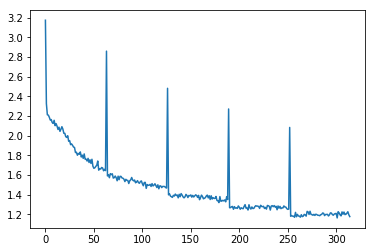

In [44]:
self_encoder = make_model(loaded_zh_embeddings, len(zh_ordered_words)).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, len(zh_ordered_words)).to(device)

AttnTrainIters(train_zh_loader, self_encoder, attn_decoder, 5, print_every=100, plot_every=100, learning_rate=0.001)

In [45]:
# #Reference lab8 1-nmt
# def greedy_selfattn_evaluate(val_loader, encoder, decoder, en_id2words):
#     #Will generate sentences 1 by 1. 
#     # process input sentence
#     decoded_words_all = []
#     decoder_attentions_all = []
    
#     with torch.no_grad():
#         encoder.eval()
#         decoder.eval()
        
#         for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
#             #if i == 5:
#             #    break
#             #batch_size, max_len = output_list.size()
#             #print(input_list.size())
            
#             # encode the source lanugage
#             encoder_outputs = encoder(input_list)

#             decoder_input = torch.tensor([[SOS_TOKEN]], device=device)  # SOS
#             decoder_hidden = torch.zeros(attn_decoder.n_layers, curr_batch, attn_decoder.hidden_size)

#             # decode the context vector
            
#             # output of this function
#             decoded_words = []
#             decoder_attentions = torch.zeros(100, 100)

#             for di in range(MAX_LENGTH):
#                 # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
#                 decoder_output, decoder_hidden, decoder_attention = decoder(
#                     decoder_input, decoder_hidden, encoder_outputs)

#                 top_score, topi = decoder_output.data.topk(1)
#                 decoder_attentions[di, :decoder_attention.size(-1)] = decoder_attention
#                 decoded_words.append(en_id2words[topi.item()])
#                 if topi.item() == EOS_TOKEN:
#                     break
#                 else:
#                     decoder_input = topi.squeeze().detach()
                    
#             decoded_words_all.append(decoded_words)
#             decoder_attentions_all.append(decoder_attentions[:di+1])

#         return decoded_words_all, decoder_attentions_all

#Reference lab8 1-nmt
def greedy_attn_evaluate(val_loader, encoder, decoder, en_id2words ):
    #Will generate sentences 1 by 1. 
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    decoded_words_all = []
    decoder_attentions_all = []
    
#     batch_size, max_input_length = input_list.size()
#     max_output_length = output_list.size(1)
    
#     loss = 0

#     encoder_outputs = self_encoder(input_list)

#     #Initialize for decoding process
# #     curr_batch = input_list.size(0)#Take the current batch size
#     decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
    
#     #decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
#     decoder_hidden = torch.zeros(1, batch_size, attn_decoder.hidden_size).to(device)
#     decoder_outputs = torch.zeros(max_output_length, batch_size, attn_decoder.output_size).to(device)
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        
        for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
            if i %100 == 0:
                print("%d/%d"%(i,len(val_loader)))
                
            batch_size, max_input_length = input_list.size()
            max_output_length = output_list.size(1)
            
            #    break
            #batch_size, max_len = output_list.size()
#             print(input_list.size())
            
            encoder_outputs = self_encoder(input_list)

            decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
#             decoder_input = torch.tensor([[SOS_TOKEN]], device=device)  # SOS
            # decode the context vector
            decoder_hidden = torch.zeros(1, batch_size, attn_decoder.hidden_size).to(device)
#             decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
            # output of this function
            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

            for di in range(MAX_LENGTH):
                # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input.reshape(1, batch_size), decoder_hidden, encoder_outputs)

                top_score, topi = decoder_output.data.topk(1)
                decoder_attentions[di, :decoder_attention.size(-1)] = decoder_attention
                decoded_words.append(en_id2words[topi.item()])
                if topi.item() == EOS_TOKEN:
                    break
                else:
                    decoder_input = topi.squeeze().detach().unsqueeze(0)
                    
            decoded_words_all.append(decoded_words)
            decoder_attentions_all.append(decoder_attentions[:di+1])

        return decoded_words_all, decoder_attentions_all

def post_process(decoded_words_all):
    cleaned_decoded_words_all = []
    
    for sentence in decoded_words_all:
        cleaned_sentence = []
        for word in sentence:
            if word == '<PAD>':
                continue
            else:
                cleaned_sentence.append(word)
        if cleaned_sentence[-1] != '<EOS>':
            cleaned_sentence.append(' <EOS>')
            
        cleaned_decoded_words_all.append(cleaned_sentence)
        
    return cleaned_decoded_words_all

#Translate the test and val lists back to english
def en_translate(index_list, en_id2words):
    translated_sentence_list = []
    for sentence in index_list:
        translated_sentence = []
        for index in sentence:
            translated_sentence.append(en_id2words[index])
        #translated_sentence.append('<EOS>')
        translated_sentence_list.append(translated_sentence)
    return translated_sentence_list



In [47]:
zh_en_val_list = [pair[1] for pair in zh_val_pairs_cleaned]
translated_sentence_list = en_translate(zh_en_val_list, en_id2words)
translated_sentence_list[0]

['when',
 'i',
 'was',
 'i',
 'remember',
 'waking',
 'up',
 'one',
 'morning',
 'to',
 'the',
 'sound',
 'of',
 'joy',
 'in',
 'my',
 'house',
 '.',
 '<EOS>']

In [48]:
decoded_val, decoder_attentions = greedy_attn_evaluate(val_zh_loader, self_encoder, attn_decoder, en_id2words)
decoded_clean = post_process(decoded_val)

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


In [49]:
from sacrebleu import corpus_bleu,raw_corpus_bleu

def bleu_score(predicted_list,translated_list):
    predicted_list_nopad = []
    for ii in range(len(predicted_list)):
        line = ''
        for jj in predicted_list[ii]:
            if jj != '<pad>':
                line = line + ' ' + jj
        predicted_list_nopad.append(line)
    labels = []
    for ii in range(len(translated_list)):
        line = ''
        for jj in translated_list[ii]:
            if jj != '<pad>':
                line = line + ' ' + jj
        labels.append(line)
    #print(len(labels))
    #print(len(predicted_list_nopad))
    print('bleu score for test dataset:', corpus_bleu(predicted_list_nopad, [labels]).score)
    print('bleu score for test dataset [raw]:', raw_corpus_bleu(predicted_list_nopad, [labels]).score)

In [50]:
bleu_score(decoded_clean,translated_sentence_list)#Reference lab8 1-nmt

bleu score for test dataset: 16.566253097257167
bleu score for test dataset [raw]: 6.4393664293720425
